In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
%matplotlib inline

In [21]:
file_name = 'Seattle_Police_Department_911_Incident_Response.csv'
df = pd.read_csv(file_name, header=0, sep=',', low_memory=False)
df.rename(columns=lambda x : x.replace(' ', '_'), inplace=True)
df.rename(columns=lambda x : x.replace('/', '_'), inplace=True)

In [22]:
df.shape

(1383463, 19)

In [23]:
data = df.dropna()
data.shape

(367019, 19)

In [24]:
data.head()

,CAD_CDW_ID,CAD_Event_Number,General_Offense_Number,Event_Clearance_Code,Event_Clearance_Description,Event_Clearance_SubGroup,Event_Clearance_Group,Event_Clearance_Date,Hundred_Block_Location,District_Sector,Zone_Beat,Census_Tract,Longitude,Latitude,Incident_Location,Initial_Type_Description,Initial_Type_Subgroup,Initial_Type_Group,At_Scene_Time
255,1658031,16000028114,201628114,161.0,TRESPASS,TRESPASS,TRESPASS,01/24/2016 11:59:45 AM,24XX BLOCK OF DEXTER AV N,D,D2,6000.1011,-122.34467,47.641580,"(47.64158, -122.34467)",NUISANCE - MISCHIEF,MISCELLANEOUS MISDEMEANORS,MISCELLANEOUS MISDEMEANORS,01/24/2016 10:46:45 AM
2146,1658050,16000028120,201628120,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:01:15 PM,42XX BLOCK OF S FINDLAY ST,R,R3,10300.2005,-122.27943,47.551933,"(47.551933, -122.27943)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:55:44 AM
2375,1658053,16000028095,201628095,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:06:53 PM,N 80 ST / GREENWOOD AV N,J,J2,2800.1003,-122.35530,47.686940,"(47.68694, -122.3553)",MOTOR VEHICLE COLLISION WITH INJURIES - PRIORI...,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,01/24/2016 10:17:27 AM
2432,1658054,16000028092,201628092,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:03:53 PM,1XX BLOCK OF NW 60 ST,B,B2,3400.3000,-122.35810,47.672348,"(47.672348, -122.3581)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:29:37 AM
2443,1658055,16000028044,201628044,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:10:26 PM,15 AV / E OLIVE ST,C,C1,7900.5006,-122.31276,47.616447,"(47.616447, -122.31276)",DUI - DRIVING UNDER INFLUENCE,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,01/24/2016 08:58:44 AM


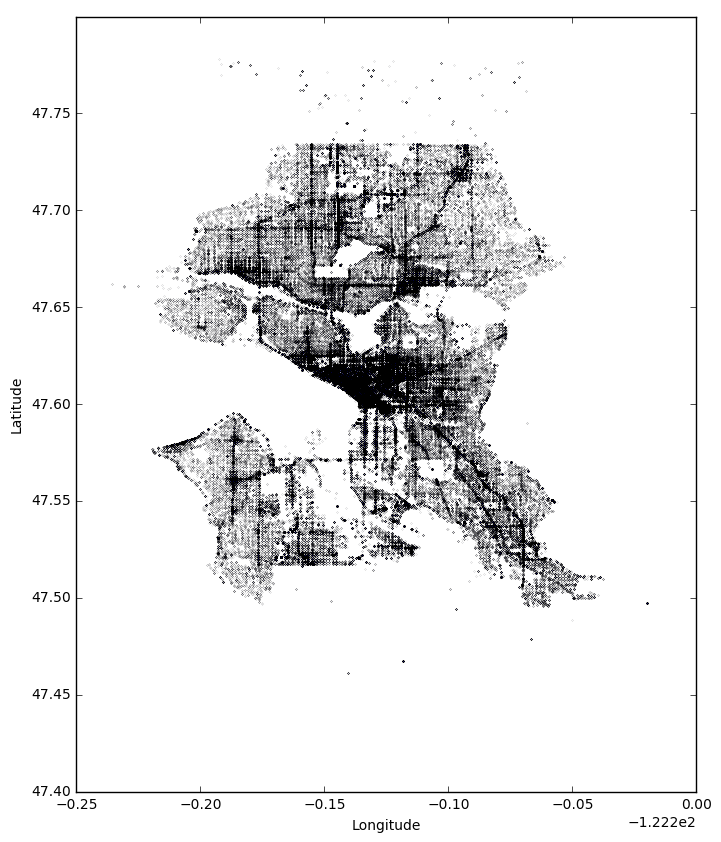

In [6]:
# Histogram
data.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', figsize = (8, 10), s = 0.005);

In [7]:
xs = np.array(data[[12]])
ys = np.array(data[[13]])

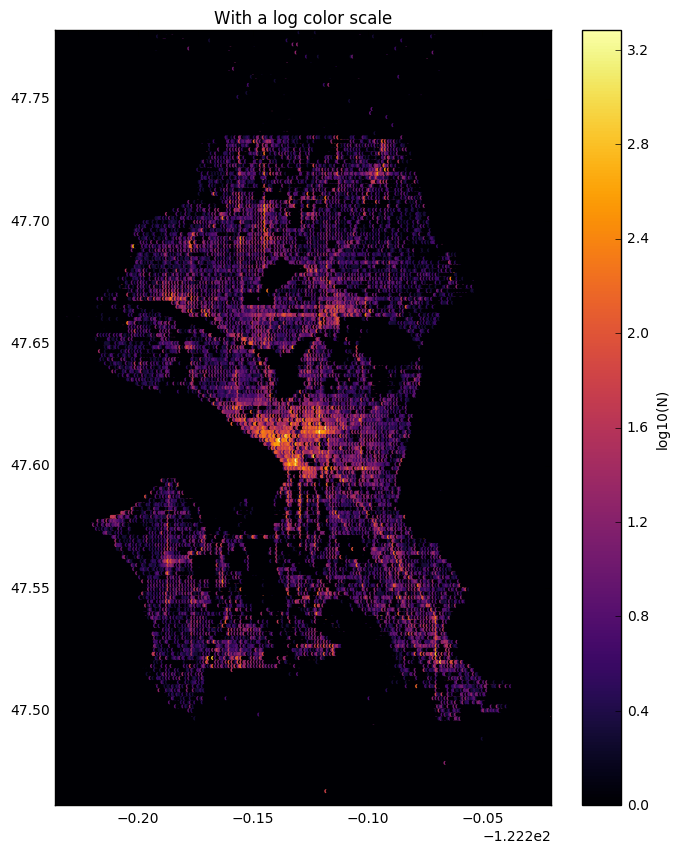

In [8]:
xmin = xs.min()
xmax = xs.max()
ymin = ys.min()
ymax = ys.max()

fig, ax = plt.subplots(figsize=(8, 10))

hb = ax.hexbin(xs, ys, gridsize=333, bins='log', cmap='inferno')
# hb = ax.hexbin(xs, ys, gridsize=300, bins='log', cmap='gnuplot')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')

In [7]:
# plot the frequency of incidents in a day
at_scene_time = data['At_Scene_Time']

# convert the datetime to 24 hour format
at_scene_time = pd.to_datetime(at_scene_time, format='%m/%d/%Y %I:%M:%S %p')
at_scene_time_hourly = at_scene_time.dt.strftime('%H')
at_scene_time_hourly = pd.to_numeric(at_scene_time_hourly)

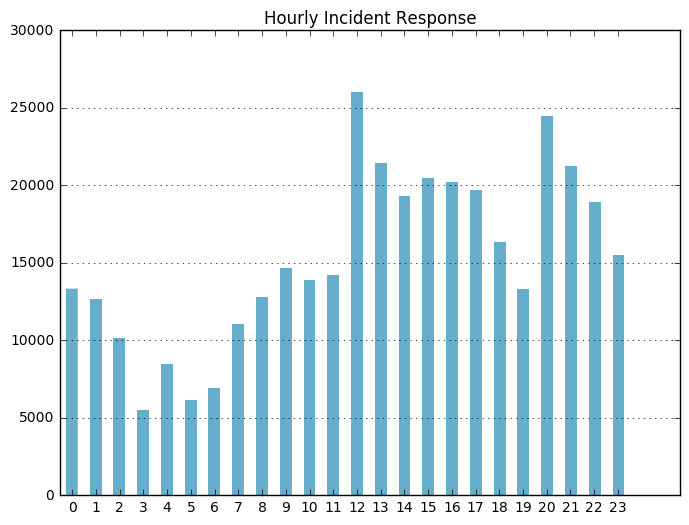

In [135]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(x = at_scene_time_hourly, bins=24, color='#67aecc', edgecolor='none',rwidth = 0.5, range = (0, 23))
ax.set_xticks(np.linspace(0.5,22.5,24)) 
ax.set_xticklabels(('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23')) 
ax.set_title("Hourly Incident Response")
ax.grid(axis = 'y')

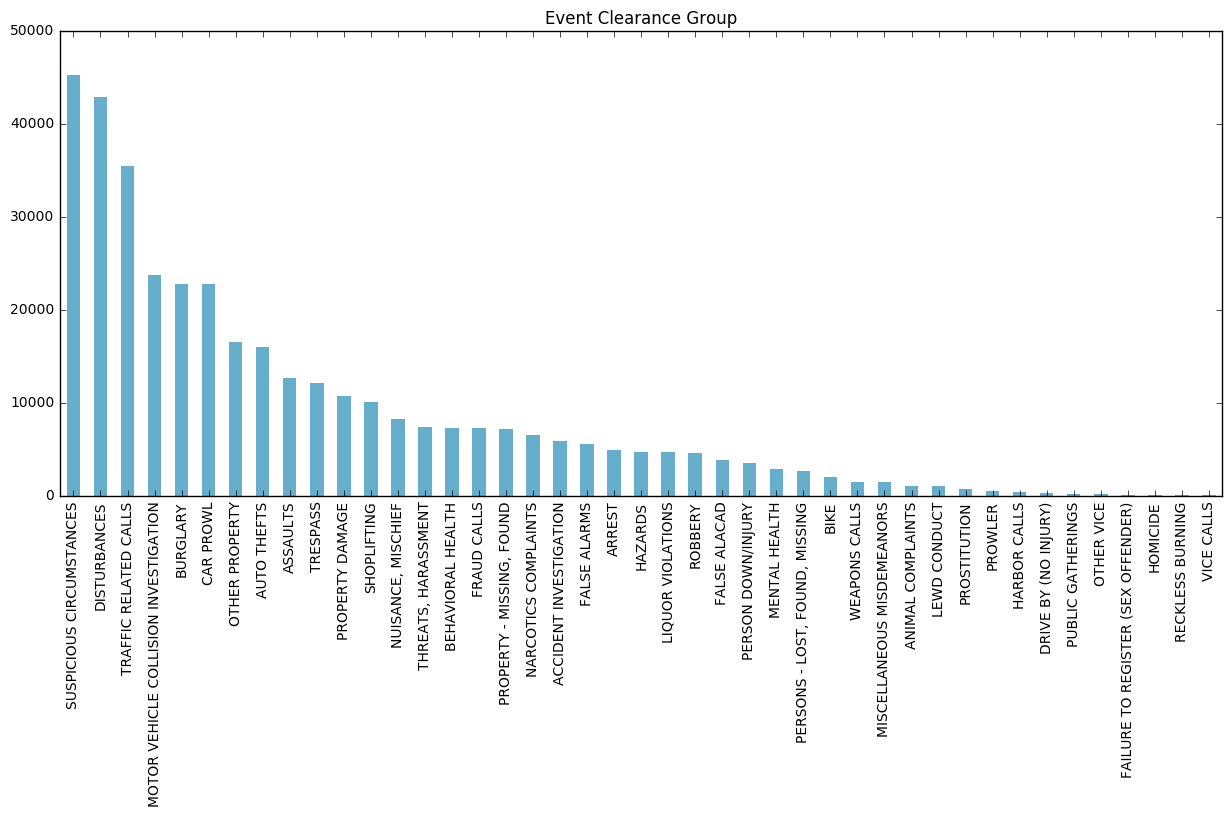

In [11]:
# Event Clearance Group count
data['Event_Clearance_Group'].value_counts().plot(kind="bar", figsize=(15, 6), 
                                                  color='#67aecc', edgecolor='none',
                                                 title='Event Clearance Group');

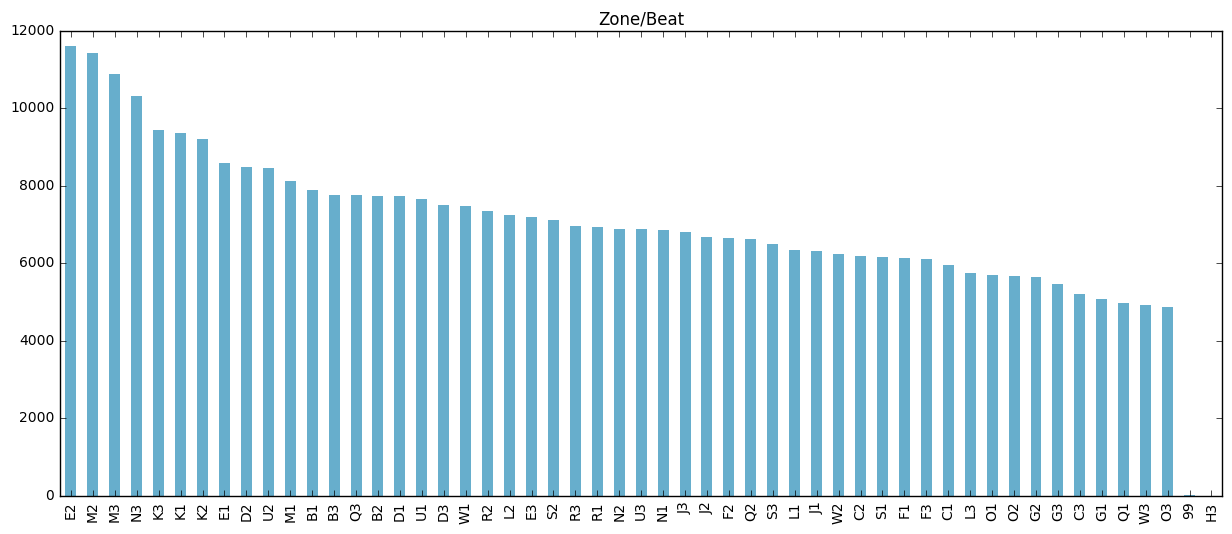

In [12]:
data['Zone_Beat'].value_counts().plot(kind = "bar", figsize= (15, 6), 
                                      color = '#67aecc', edgecolor='none',
                                     title='Zone_Beat');

In [13]:
# convert the datetime to 10 minutes interval and add it to dataset as a new column 
pd.options.mode.chained_assignment = None  # default='warn'

at_scene_time_minute = pd.DatetimeIndex(at_scene_time).round('10min')
at_scene_time_minute = at_scene_time_minute.strftime('%H:%M')
data['At_Scene_Time_Minute'] = at_scene_time_minute
data['At_Scene_Time_Minute'].head()

255     10:50
2146    11:00
2375    10:20
2432    10:30
2443    09:00
Name: At Scene Time Minute, dtype: object

In [25]:
data.head()

,CAD_CDW_ID,CAD_Event_Number,General_Offense_Number,Event_Clearance_Code,Event_Clearance_Description,Event_Clearance_SubGroup,Event_Clearance_Group,Event_Clearance_Date,Hundred_Block_Location,District_Sector,Zone_Beat,Census_Tract,Longitude,Latitude,Incident_Location,Initial_Type_Description,Initial_Type_Subgroup,Initial_Type_Group,At_Scene_Time
255,1658031,16000028114,201628114,161.0,TRESPASS,TRESPASS,TRESPASS,01/24/2016 11:59:45 AM,24XX BLOCK OF DEXTER AV N,D,D2,6000.1011,-122.34467,47.641580,"(47.64158, -122.34467)",NUISANCE - MISCHIEF,MISCELLANEOUS MISDEMEANORS,MISCELLANEOUS MISDEMEANORS,01/24/2016 10:46:45 AM
2146,1658050,16000028120,201628120,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:01:15 PM,42XX BLOCK OF S FINDLAY ST,R,R3,10300.2005,-122.27943,47.551933,"(47.551933, -122.27943)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:55:44 AM
2375,1658053,16000028095,201628095,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:06:53 PM,N 80 ST / GREENWOOD AV N,J,J2,2800.1003,-122.35530,47.686940,"(47.68694, -122.3553)",MOTOR VEHICLE COLLISION WITH INJURIES - PRIORI...,MOTOR VEHICLE COLLISION INVESTIGATION,TRAFFIC RELATED CALLS,01/24/2016 10:17:27 AM
2432,1658054,16000028092,201628092,50.0,"BURGLARY - RESIDENTIAL, UNOCCUPIED",RESIDENTIAL BURGLARIES,BURGLARY,01/24/2016 12:03:53 PM,1XX BLOCK OF NW 60 ST,B,B2,3400.3000,-122.35810,47.672348,"(47.672348, -122.3581)",BURG - RES (INCL UNOCC STRUCTURES ON PROP),BURGLARY,RESIDENTIAL BURGLARIES,01/24/2016 10:29:37 AM
2443,1658055,16000028044,201628044,430.0,MOTOR VEHICLE COLLISION,TRAFFIC RELATED CALLS,MOTOR VEHICLE COLLISION INVESTIGATION,01/24/2016 12:10:26 PM,15 AV / E OLIVE ST,C,C1,7900.5006,-122.31276,47.616447,"(47.616447, -122.31276)",DUI - DRIVING UNDER INFLUENCE,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,01/24/2016 08:58:44 AM
